In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import networkx as nx
import importlib
import sys
sys.path.append("../")
import chebygin as my_models
import attention_pooling
import utils
from utils import *
import graphdata

# Visualizations for PROTEINS

In [2]:
device = 'cpu'
def load_model(model_path, in_features=1, out_features=2, my_models=my_models):
    importlib.reload(utils)
    importlib.reload(attention_pooling)
    importlib.reload(my_models)
    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    model = my_models.ChebyGIN(in_features=in_features,
                              out_features=out_features,
                              K=state['args'].filter_scale,
                              filters=state['args'].filters,
                              dropout=state['args'].dropout,
                              n_hidden=state['args'].n_hidden,
                              aggregation=state['args'].aggregation,
                              pool=state['args'].pool,
                              pool_arch=state['args'].pool_arch)
    print(model)
    model.train()
    print('model capacity: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

    keys = list(state['state_dict'].keys())
    for key in keys:
        if key.find('layers') == 0:
            key_new = key.replace('layers', 'graph_layers')
            state['state_dict'][key_new] = state['state_dict'][key].clone()
            del state['state_dict'][key]
    try:
        model.load_state_dict(state['state_dict'])
    except Exception as e:
        print('ERROR!!!')
        print(e)
        raise
    model.eval()
    model.to(device)
    return model

In [3]:
def get_graph(data_test, index, draw=True):
    A = data_test.adj_list[index]
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G)
    if draw:
        nx.draw(G, pos, node_size=200, node_color=np.ones(3), edgecolors=np.zeros(3))
        plt.show()
        print('label', data_test.labels[index])
    return A, G, pos

In [4]:
edgecolors = [0.5, 0.5, 0.5, 0.1] #np.zeros(3)
cmap = 'Purples'
edgewidth = 0.3

def plot_pooled(index, alpha, thresh):
    fig = plt.figure()
    A = data_test.adj_list[index].copy()
    idx = np.where(alpha[index] > thresh)[0]    
    n = len(idx)
    A = A[:,idx][idx, :]
    G = nx.from_numpy_array(A)
    pos_new = {}
    for j in range(len(idx)):
        pos_new[j] = pos[idx[j]] #+ np.array([0, -0.1])        
    
    idx_d = np.where(alpha[index] <= thresh)[0]
    if len(idx_d) > 0:            
        G_dummy = nx.from_numpy_array(data_test.adj_list[index][:,idx_d][idx_d, :])
        pos_dummy = {}
        for j in range(len(idx_d)):
            pos_dummy[j] = pos[idx_d[j]]        
        nx.draw(G_dummy, pos_dummy, node_color=np.ones((len(pos_dummy), 3)), edge_color='w',
                               node_size=100, width=0, alpha=0)
        
    vmin = alpha[index].min()
    vmax = alpha[index].max()
    colors = alpha[index].copy()[idx]
    nx.draw(G, pos_new, node_color=colors, node_size=100, with_labels=False, width=edgewidth,
                     edgecolors=edgecolors, cmap=cmap, vmin=vmin, vmax=vmax)
    
    return n

In [6]:
datareader = graphdata.DataReader(data_dir='../data/PROTEINS',
                                  rnd_state=np.random.RandomState(111),
                                  N_nodes=25,
                                  use_cont_node_attr=False,
                                  folds=0)
data_train = graphdata.GraphData(datareader, 0, split='train_val')
data_test = graphdata.GraphData(datareader, 0, split='test')

loading data from /mnt/data/bknyazev/data/graph_data/PROTEINS/data.pkl
548/1113 graphs with at least 25 nodes
The degree_feature argument is ignored for this dataset. 
        It will automatically be set to True if nodes do not have any features. Otherwise it will be set to False
TRAIN_VAL: 500/1113
Class 0: 			207 samples
Class 1: 			293 samples
The degree_feature argument is ignored for this dataset. 
        It will automatically be set to True if nodes do not have any features. Otherwise it will be set to False
TEST: 613/1113
Class 0: 			456 samples
Class 1: 			157 samples


In [7]:
model_wsup = load_model('../checkpoints/checkpoint_TU_657452_epoch50_seed0000111.pth.tar', 3)

ChebyGINLayer torch.Size([64, 9]) tensor([0.5897, 0.5197, 0.7419, 0.6886, 0.7193, 0.3807, 0.5801, 0.5141, 0.6064,
        0.6040], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 192]) tensor([0.5736, 0.5963, 0.5681, 0.5543, 0.5949, 0.5693, 0.6047, 0.5923, 0.5128,
        0.5877], grad_fn=<SliceBackward>)
Default PyTorch init is used for layer torch.Size([1, 64]), std=0.067
p values [ 0.06793003  0.10320054  0.10634305  0.05612151 -0.04794677 -0.03093022
  0.12310359 -0.09784283 -0.00628568  0.03255409 -0.02292022  0.03407994
  0.03726263  0.00449096 -0.03368787  0.06759524  0.02463372  0.01248077
 -0.08960181  0.11157469 -0.03368744 -0.11200798 -0.02445324 -0.0382366
  0.08179064 -0.04915699 -0.06789757  0.09074202 -0.04305653  0.01185144
 -0.05244382  0.05026504  0.02931918  0.02291638  0.01423423  0.07063276
 -0.01804945 -0.12416753 -0.03334883 -0.10381347  0.01444583 -0.08961287
  0.01378526 -0.02912359  0.10005845 -0.04555489 -0.08360025 -0.05573043
  0.10871398  0.09476548

In [8]:
pred_wsup, pred_unsup, pred_global, alpha_wsup, alpha_unsup = [], [], [], [], []
for index in range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = A.shape[0]
    data = [torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
                torch.from_numpy(A).unsqueeze(0).float().to(device).to(device).expand(2, -1, -1),
                torch.ones(2, n, dtype=torch.uint8).to(device),
                torch.zeros(2).to(device),
                {'N_nodes': torch.zeros(2, 1).long().to(device) + n,
                 'node_attn': torch.zeros(2, n).float().to(device)}]
    y, output = model_wsup(copy_batch(data))
    alpha_wsup.append(output['alpha'][0][0].data.numpy())
    pred_wsup.append(torch.argmax(y[0]).item())
    
    
print(len(pred_wsup), len(alpha_wsup), len(pred_unsup), len(alpha_unsup))
print(np.mean(np.equal(np.array(pred_wsup), data_test.labels)))

613 613 0 0
0.7732463295269169


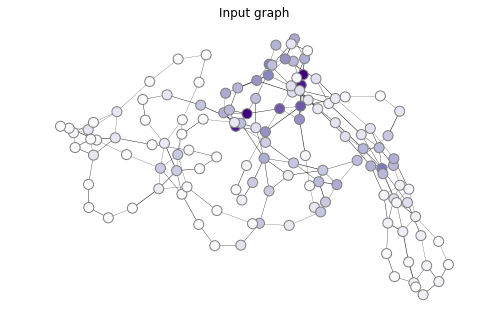

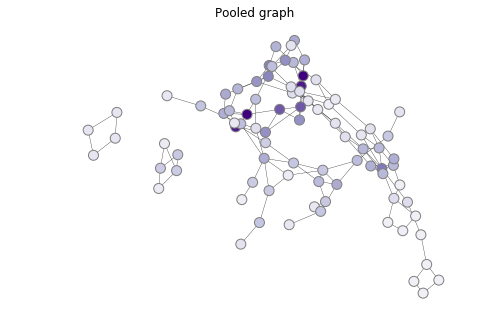

In [18]:
thresh = 0.005
c = 0
for index in [437]: #range(len(data_test.labels)):
    A, G, pos = get_graph(data_test, index, draw=False)
    n = A.shape[0]
    if n < 25:
        continue
#     label = data_test.labels[index]    
#     pred = pred_wsup[index]
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_wsup[index], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.title('Input graph')
    plt.show()
    
    n = plot_pooled(index, alpha_wsup, thresh)
    plt.axis('off')
    plt.title('Pooled graph')
    plt.show()
    
    if c >= 5:
        break
        
    c += 1